Generate fake data

In [1]:
import os
from tqdm import tqdm
import pandas as pd
from datasets import load_dataset

save_dir = '/home/nasserm/local/zoobot/examples/finetuning/tmp/metadata/imgs'

# load both splits
im_ds_dict = load_dataset("mwalmsley/is-lsb")

for split in ['train', 'test']:
    # convert split to pandas DataFrame
    im_ds = im_ds_dict[split]
    df: pd.DataFrame = im_ds.with_format("pandas")[:]

    # save dataset metadata as CSV
    df.to_csv(f'{save_dir}/{split}_dataset.csv', index=False)

    # make image directory
    os.makedirs(f'{save_dir}/images/{split}', exist_ok=True)

    # save each image
    for _, row in tqdm(df.iterrows(), total=len(df)):
        id_str = row['id_str']
        img = row['image']  # already PIL.Image.Image
        img.save(f'{save_dir}/images/{split}/{id_str}.jpg')

100%|██████████| 863/863 [00:00<00:00, 916.83it/s]


In [2]:
df_train = pd.read_csv('imgs/train_dataset.csv')
df_test = pd.read_csv('imgs/test_dataset.csv')

df_train= df_train.reset_index(drop=True) 
df_test=df_test.reset_index(drop=True) 

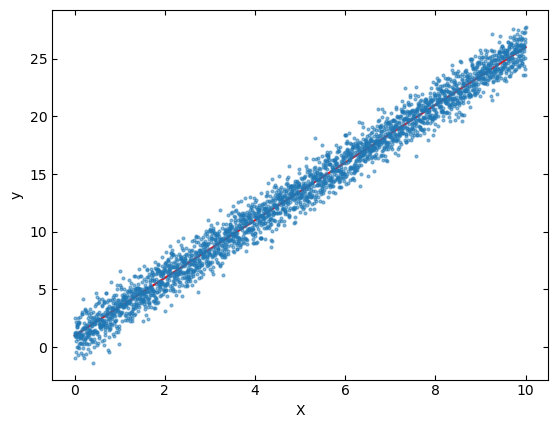

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(14) 

n = (2014+864)   
slope = 2.5     
b = 1.0    
noise_std = 1.0    

X = np.linspace(0, 10, n)
noise = np.random.normal(0, noise_std, n)
y = slope * X + b + noise


df = pd.DataFrame({'X': X, 'y':y})

fig, ax = plt.subplots()
ax.scatter(df['X'], df['y'], label="Data with noise", s=4, alpha=0.5)
ax.plot(df['X'], slope*df['X'] + b, color="red", label="True line", zorder=0)
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.tick_params(direction='in')
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)

Add pair images to the fake data

In [4]:
from sklearn.model_selection import train_test_split
train_, test_ = train_test_split(df, test_size=864, train_size=2014, random_state=14)

In [5]:
train_

,X,y
1138,3.955509,9.051425
2656,9.231839,23.476162
437,1.518943,2.276750
2859,9.937435,25.216443
1617,5.620438,16.640429
...,...,...
2375,8.255127,21.467994
2454,8.529718,22.153967
1292,4.490789,11.934551
1368,4.754953,13.285819


In [6]:
train_=train_.reset_index(drop=True) 
test_ = test_.reset_index(drop=True) 

In [7]:
df_train[['X', 'y']] = train_[['X', 'y']]
df_test[['X', 'y']] = test_[['X', 'y']]

In [11]:
df_train.to_csv('imgs/train_dataset.csv', index=False)
df_test.to_csv('imgs/test_dataset.csv', index=False)

In [9]:
df_train.head()

,image,label,id_str,X,y
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,a17e8ab7a7de9c79d3cf960af591bfd113669e405a9803...,3.955509,9.051425
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1,2acac60ba3f744afb21f2e6c59d876949c8305e4f519cf...,9.231839,23.476162
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,50f422c99ac53ecdfb5559fb71e758c7052f3f4ad74e58...,1.518943,2.276750
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,12fba589f6f7b0a3ce5c17039760b3c98e1cd6b69a9c1f...,9.937435,25.216443
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1,f69e6578faa676168e96e9e4595fb79fff28aee64fd6bf...,5.620438,16.640429


In [ ]:
from galaxy_datasets.pytorch.galaxy_datamodule import CatalogDataModule
from galaxy_datasets.transforms import default_view_config, get_galaxy_transform
batch_size=32
num_workers=64


transform_cfg = default_view_config()
transform = get_galaxy_transform(transform_cfg)


datamodule = CatalogDataModule(
use_columns = ['y', 'X'],
catalog = df_train,
train_transform = transform,
test_transform = transform,
batch_size= batch_size,
num_workers= num_workers
)

GZDESI/GZRings/GZCD not available from galaxy_datasets.pytorch.datasets - skipping


In [ ]:
from zoobot.pytorch.training.finetune import FinetuneableZoobotRegressor
model = FinetuneableZoobotRegressor(

    name='nassm/convnext_nano',
    n_blocks=5, 
    learning_rate=1e-6,  
    lr_decay=0.5, 

    unit_interval=True
)